In [1]:
import jax
import jax.numpy as jnp
import sys
import os
from functools import partial
import jax
from jax import numpy as jnp
import numpy as onp
import math
from lean.distributions import CenteredNormal
from lean.samplers import OverdampedLangevinDynamics
from flax.core import FrozenDict
from scripts.dw2.run_ld import N_PARTICLES


N_SAMPLES = 10
N_PARTICLES = 4
N_DIM = 2

def potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        **kwargs,
):
    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5

    energy = (1 / (2 * tao)) * (
        a * (x - d0)
        + b * (x - d0) ** 2
        + c * (x - d0) ** 4
    )
    return energy

def cos(t):
    return jnp.cos(0.5 * t / math.pi)

def sin(t):
    return jnp.sin(0.5 * t / math.pi)

def coefficient(t, a, b):
    return jax.scipy.special.betainc(a, b, t)

def ess(log_w):
    # normalize
    w = jax.nn.softmax(log_w)
    ess = 1 / (w ** 2).sum()
    return ess

def time_dependent_potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        time=0.0,
        schedule_gaussian=None,
        schedule_a=None,
        schedule_b=None,
        schedule_c=None,
        log_sigma=None,

):
    # gaussian_potential = jax.scipy.stats.norm.logpdf(x, scale=scale).sum(-1).sum(-1).mean()

    gaussian_potential = CenteredNormal(log_sigma).log_prob(x).sum(-1).sum(-1).mean()
    gaussian_potential = (1 - schedule_gaussian(time)) * gaussian_potential

    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5
    x = x.reshape(*x.shape[:-2], -1)
    a_term = a * (x - d0)
    b_term = b * (x - d0) ** 2
    c_term = c * (x - d0) ** 4

    a_term = a_term * schedule_a(time)
    b_term = b_term * schedule_b(time)
    c_term = c_term * schedule_c(time)
    energy = (1 / (2 * tao)) * (a_term + b_term + c_term).sum(-1).mean()
    energy = energy + gaussian_potential
    return energy

def compute_log_w(schedules, sampler_params, key):
    schedule_gaussian, schedule_a, schedule_b, schedule_c = schedules
    key, key_x = jax.random.split(key, 2)
    x = CenteredNormal(0.0).sample(key_x, (N_SAMPLES, N_PARTICLES, N_DIM))
    h = jnp.zeros((N_SAMPLES, N_PARTICLES, N_DIM))
    
    _time_dependent_potential = partial(
        time_dependent_potential,
        schedule_gaussian=schedule_gaussian,
        schedule_a=schedule_a,
        schedule_b=schedule_b,
        schedule_c=schedule_c,
        log_sigma=0.0,
    )
    
    sampler = OverdampedLangevinDynamics(
        potential=_time_dependent_potential,
        **sampler_params,
    )
    
    x, delta_S = sampler(x, key=key)
    ut = potential(x).sum(-1).sum(-1)
    u0 = -CenteredNormal(0.0).log_prob(x).sum(-1).sum(-1)
    jax.debug.print("{ut}, {u0}, {delta_S}", ut=ut.mean(), u0=u0.mean(), delta_S=delta_S.mean())
    
    log_w = -ut +u0 + delta_S
    return log_w

(10, 1000, 4)


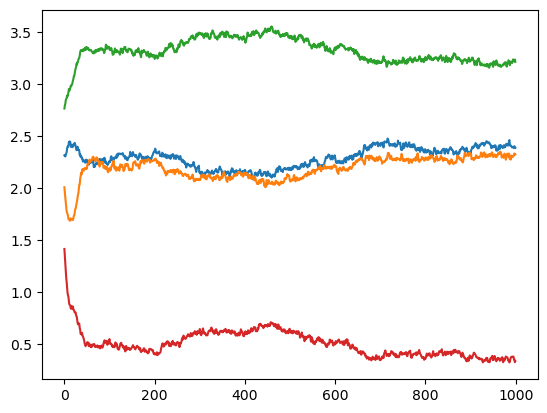

In [4]:
sampler_args = {
    'step_size': 1e-3,
    'time': 1.0,
}
num_steps = int(1.0 / sampler_args['step_size'])
sampler_args = FrozenDict(sampler_args)
sampler = OverdampedLangevinDynamics(
    potential=potential,
    **sampler_args,
)
x = CenteredNormal(0.0).sample(jax.random.PRNGKey(0), (N_SAMPLES, N_PARTICLES, N_DIM))

keys = jax.random.split(jax.random.PRNGKey(2666), num_steps)
distances = []
delta_S = 0.0
for idx in range(num_steps):
    x, delta_S = sampler.step(
        position=x,
        delta_S=delta_S,
        key=keys[idx],
        temperature=1e-2,
    )
    distance = jnp.linalg.norm(x, axis=-1)
    distances.append(distance)
distances = jnp.stack(distances, axis=0)
distances = distances.swapaxes(0, 1)
print(distances.shape)

from matplotlib import pyplot as plt
plt.plot(distances[1])